In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import torch
from torch import nn
from easy_tpp.preprocess.event_tokenizer import EventTokenizer
from easy_tpp.config_factory import DataSpecConfig
from models.encoders.gru import GRUTPPEncoder
from models.decoders.rmtpp import RMTPPDecoder, RMTPPLoss
from models import TPPModel, VAETPPModel
from torch.utils.data import DataLoader, Dataset
from utils.evaluatetpp import evaluate_tpp_model, evaluate_vae_model, calculate_event_metrics
from scipy import integrate

import scienceplots
plt.style.use(['science'])

# font sizes
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'axes.labelsize': 18})
plt.rcParams.update({'legend.fontsize': 16})

In [2]:
def preprocess_data(raw_data):
    # Validate input
    if not raw_data:
        raise ValueError("Input data is empty")
        
    # Create input data dictionary
    input_data = {
        'time_seqs': [[x["time_since_start"] for x in seq] for seq in raw_data],
        'type_seqs': [[x["type_event"] for x in seq] for seq in raw_data],
        'time_delta_seqs': [[x["time_since_last_event"] for x in seq] for seq in raw_data]
    }

    filtered_data = {
        k: [seq for seq in v if len(seq) > 0]
        for k, v in input_data.items()
    }
    
    if not filtered_data['type_seqs']:
        raise ValueError("No valid sequences found after filtering (all sequences were empty)")
        
    return filtered_data

def collate_fn(batch, config):
    tokenizer = EventTokenizer(config)
    tokenizer.padding_side = 'right'
    seq_lengths = [batch_item['sequence_length'] for batch_item in batch]  
    padded_batch = tokenizer.pad(batch, 
                                 return_tensors='pt',
                                 return_attention_mask=None,
                                 padding='longest')
    padded_batch['sequence_length'] = torch.tensor(seq_lengths)
    
    return padded_batch

class EventDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['type_seqs'])

    def __getitem__(self, idx):
        return {
            'time_seqs': self.data['time_seqs'][idx],
            'type_seqs': self.data['type_seqs'][idx],
            'time_delta_seqs': self.data['time_delta_seqs'][idx],
            'sequence_length': len(self.data['type_seqs'][idx])
        }

In [3]:
def plot_event_sequence(time_seqs, type_seqs, time_delta_seqs, sequence_length, calculated_deltas, decoder_output, num_samples=5):
    for i in range(num_samples):
        time_seq = time_seqs[i].detach().cpu().numpy()
        type_seq = type_seqs[i].detach().cpu().numpy()
        time_delta_seq = time_delta_seqs[i].detach().cpu().numpy()
        seq_len = sequence_length[i].item()
        pred_time_delta_seq = calculated_deltas[i].detach().cpu().numpy() if calculated_deltas is torch.Tensor else calculated_deltas
        pred_mark_logits = decoder_output.mark_logits[i].detach().cpu().numpy()

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(time_seq[:seq_len], type_seq[:seq_len], 'o-', label='True')
        plt.plot(time_seq[:seq_len], np.argmax(pred_mark_logits[:seq_len], axis=-1), 'o-', label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Event Type')
        plt.title('Event Sequence')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(time_seq[:seq_len], time_delta_seq[:seq_len], 'o-', label='True')
        plt.plot(time_seq[:seq_len], pred_time_delta_seq[:seq_len], 'o-', label='Calculated')
        plt.xlabel('Time')
        plt.ylabel('Time Delta')
        plt.title('Time Delta Sequence')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [61]:
dev_dict = pkl.load(open('data/taxi/dev.pkl', 'rb'))
test_dict = pkl.load(open('data/taxi/test.pkl', 'rb'))
train_dict = pkl.load(open('data/taxi/train.pkl', 'rb'))

train_data = train_dict['train']
test_data = test_dict['test']
dev_data = dev_dict['dev']


dim_process = train_dict['dim_process']
config = DataSpecConfig.parse_from_yaml_config({
    'num_event_types': dim_process,
    'pad_token_id': dim_process
})


# Create datasets
preprocessed_train = preprocess_data(train_data)
preprocessed_test = preprocess_data(test_data)

train_dataset = EventDataset(preprocessed_train)
test_dataset = EventDataset(preprocessed_test)

# Create data loaders with collate function and arguments to prepare_data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)

In [68]:
HIDDEN_DIM = 128
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

tpp_model = TPPModel(config, hidden_dim=HIDDEN_DIM, mlp_dim=MLP_DIM, device=device).to(device)

# Training loop
num_epochs = 200
optimizer = torch.optim.Adam(tpp_model.parameters(), lr=0.001)

# load the model
try:
    tpp_model.load_state_dict(torch.load('models/tpp_model.pt'))
    print("Model loaded successfully, skipping training.")
except FileNotFoundError:
    print("Model not found, starting training from scratch.")

Model loaded successfully, skipping training.


/tmp/ipykernel_2242253/2944073584.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tpp_model.load_state_dict(torch.load('models/tpp_model.pt'))


In [81]:
def conditional_intensity(model, time_logits, time_delta_seqs):
    # get the base intensity
    base_intensity = model.decoder.intensity_b

    # get the conditional intensity
    cond_intensity = torch.exp(time_logits + model.decoder.intensity_w * time_delta_seqs + base_intensity)

    return cond_intensity

Shape of time logits:  torch.Size([32, 38])
Shape of mark logits:  torch.Size([32, 38, 10])
torch.Size([32, 38])
Shape of mask:  torch.Size([38])
Shape of cond intensity:  torch.Size([36])


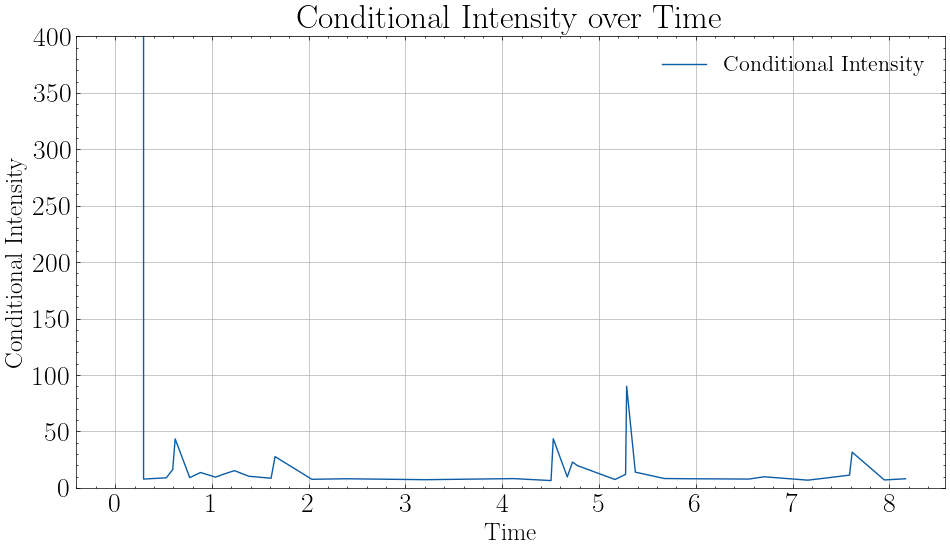

In [92]:
batch = next(iter(test_loader))

base_intensity = tpp_model.decoder.intensity_b

# get mask for the batch according to the sequence length
mask = torch.arange(batch['time_seqs'].shape[1]).expand(len(batch['time_seqs']), batch['time_seqs'].shape[1]) < batch['sequence_length'].unsqueeze(1)

# get one batch from the test loader
batch = next(iter(test_loader))
batch = {k: v.to(device) for k, v in batch.items()}

decoder_output = tpp_model(batch)
time_logits = decoder_output[0].squeeze()
mark_logits = decoder_output[1]

print("Shape of time logits: ", time_logits.shape)
print("Shape of mark logits: ", mark_logits.shape)

# get one time_delta_seq from the batch
time_delta_seq = batch['time_delta_seqs'][0].to(device)
masked_time_delta_seq = time_delta_seq[mask[0]]
masked_time_logits = time_logits[0][mask[0]]

# get one time logits from the batch
print(time_logits.shape)

cond_intensity = conditional_intensity(tpp_model, masked_time_logits, masked_time_delta_seq)
time_seqs = batch['time_seqs'][0].to(device)

# mask the time sequences
time_seqs = time_seqs[mask[0]]

print("Shape of mask: ", mask[0].shape)
print("Shape of cond intensity: ", cond_intensity.shape)

# plot the intensity function
plt.figure(figsize=(10, 6))
plt.plot(time_seqs.detach().cpu().numpy(), cond_intensity.detach().cpu().numpy(), label='Conditional Intensity')
plt.xlabel('Time')
plt.ylabel('Conditional Intensity')
plt.title('Conditional Intensity over Time')
plt.legend()

# limit y-axis for better visualization to roundoff omitting outliers
plt.ylim(0, 400)

plt.grid(True)
plt.tight_layout()
plt.savefig('tpp_cond_intensity.png')
plt.show()

In [73]:
# load vaetpp model
HIDDEN_DIM = 128
LATENT_DIM = 32
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

# calculate the number of steps for beta annealing and warmup
num_epochs = 200
num_steps = len(train_loader) * num_epochs
cyclic_steps = num_steps // 5
warmup_steps = len(train_loader) * 20

vae_model = VAETPPModel(config, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, mlp_dim=MLP_DIM, device=device, beta_steps=num_steps, warmup_steps=warmup_steps, beta_start=0, beta_end=0.5, l1_lambda=0.000, l2_lambda=0.000).to(device)

# load
try:
    vae_model.load_state_dict(torch.load('models/vae_model.pt'))
    print("Model loaded successfully, skipping training.")
except FileNotFoundError:
    print("Model not found, starting training from scratch.")

Model loaded successfully, skipping training.


/tmp/ipykernel_2242253/3841778593.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('models/vae_model.pt'))


In [74]:
# test computation of conditional intensity
batch = next(iter(test_loader))
batch = {k: v.to(device) for k, v in batch.items()}
time_seqs = batch['time_seqs']
time_delta_seqs = batch['time_delta_seqs']
sequence_length = batch['sequence_length']
mask = torch.arange(time_seqs.shape[1]).expand(len(time_seqs), time_seqs.shape[1]) < sequence_length.unsqueeze(1)

# get the time logits
time_logits = vae_model.decoder.time_logits(time_seqs)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

Selected mu shape: torch.Size([38, 32])
Selected logvar shape: torch.Size([38, 32])
Computed std shape: torch.Size([38, 32])
z_samples shape: torch.Size([100, 38, 32])
Decoding realization 1/100, z shape: torch.Size([1, 38, 32])
Selected time_logits shape: torch.Size([36])
Computed cond_intensity shape: torch.Size([36])
Decoding realization 2/100, z shape: torch.Size([1, 38, 32])
Selected time_logits shape: torch.Size([36])
Computed cond_intensity shape: torch.Size([36])
Decoding realization 3/100, z shape: torch.Size([1, 38, 32])
Selected time_logits shape: torch.Size([36])
Computed cond_intensity shape: torch.Size([36])
Decoding realization 4/100, z shape: torch.Size([1, 38, 32])
Selected time_logits shape: torch.Size([36])
Computed cond_intensity shape: torch.Size([36])
Decoding realization 5/100, z shape: torch.Size([1, 38, 32])
Selected time_logits shape: torch.Size([36])
Computed cond_intensity shape: torch.Size([36])
Decoding realization 6/100, z shape: torch.Size([1, 38, 32])
S

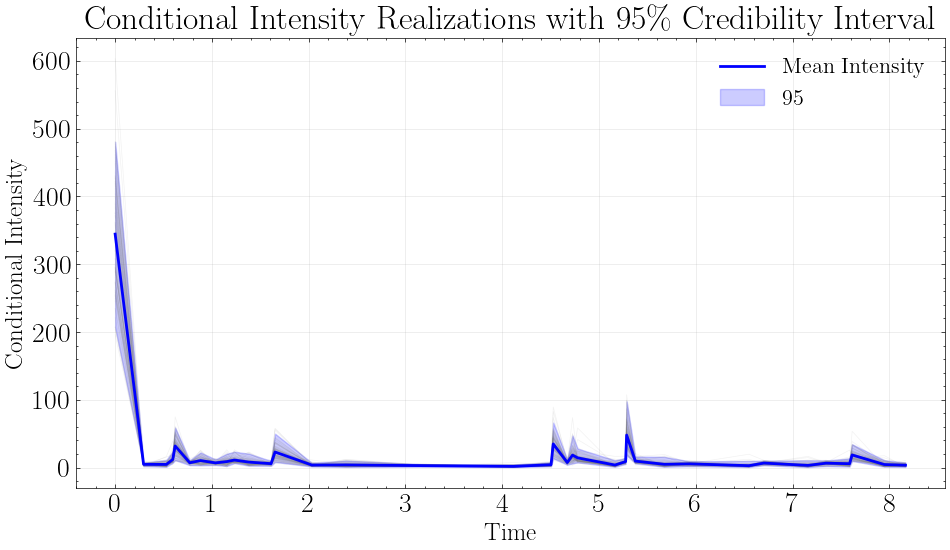

<Figure size 350x262.5 with 0 Axes>

In [94]:
def sample_vae_latent_space(model, data_loader, device, num_samples=100, use_posterior=True):
    """
    Sample from the VAE latent space for temporal point processes.
    
    Args:
        model: The VAE model
        data_loader: DataLoader containing the input data
        device: Device to run the model on
        num_samples: Number of samples to generate
        use_posterior: If True, sample from posterior distribution. If False, sample from prior.
    
    Returns:
        numpy.ndarray: Sampled points from the latent space
    """
    model.eval()
    
    if use_posterior:
        # Get a batch of data
        batch = next(iter(data_loader))
        batch = {k: v.to(device) for k, v in batch.items()}
        sequence_lengths = batch["sequence_length"].to(device)
        
        # Identify the padding tokens
        mask = torch.arange(batch["type_seqs"].size(1)).unsqueeze(0).to(device) < sequence_lengths.unsqueeze(1)
        mask = mask.cpu().numpy()
        
        with torch.no_grad():
            output = model(batch)
            mu = output.mu.cpu().numpy()
            logvar = output.logvar.cpu().numpy()
            
            mu = mu[mask].reshape(-1, mu.shape[-1])
            logvar = logvar[mask].reshape(-1, logvar.shape[-1])
            
            if len(mu) > num_samples:
                idx = np.random.choice(len(mu), num_samples, replace=False)
                mu = mu[idx]
                logvar = logvar[idx]
        
        # Sample from the posterior N(μ, σ²)
        std = np.exp(0.5 * logvar)
        samples = mu + np.random.randn(*mu.shape) * std
        
    else:
        # Sample from the prior N(0, I)
        latent_dim = model.latent_dim  # Assuming your model has this attribute
        samples = np.random.randn(num_samples, latent_dim)
    
    return samples


import torch
import numpy as np
import matplotlib.pyplot as plt

def compute_multiple_realizations_single_sample(vae_model, data_loader, device, num_realizations=50, sample_index=0):
    """
    Compute and visualize multiple realizations of the conditional intensity function
    for a single data sample, demonstrating the probabilistic nature of the model.

    Args:
        vae_model: The trained VAETPPModel.
        data_loader: DataLoader containing the input data.
        device: Device to run the model on.
        num_realizations: Number of realizations to generate.
        sample_index: Index of the sample in the batch to visualize.

    Returns:
        matplotlib.figure.Figure: The plotted figure with realizations and credibility intervals.
    """
    vae_model.eval()
    
    # Get a batch of data
    batch = next(iter(data_loader))
    batch = {k: v.to(device) for k, v in batch.items()}
    sequence_lengths = batch["sequence_length"].to(device)
    
    # Select the specific sample from the batch
    selected_sequence_length = sequence_lengths[sample_index]
    selected_time_delta_seq = batch['time_delta_seqs'][sample_index][:selected_sequence_length]
    selected_time_seq = batch['time_seqs'][sample_index][:selected_sequence_length]
    selected_mask = torch.arange(batch["type_seqs"].size(1)).to(device) < selected_sequence_length.unsqueeze(0)
    
    with torch.no_grad():
        # Encode to get mu and logvar for the selected sample
        output = vae_model(batch)
        mu = output.mu[sample_index]      # Shape: (sequence_length, latent_dim)
        logvar = output.logvar[sample_index]  # Shape: (sequence_length, latent_dim)
        
        print(f"Selected mu shape: {mu.shape}")       # Debugging
        print(f"Selected logvar shape: {logvar.shape}")  # Debugging
        
        # Compute standard deviation
        std = torch.exp(0.5 * logvar)
        print(f"Computed std shape: {std.shape}")     # Debugging
        
        # Sample multiple z's from the posterior
        z_samples = mu.unsqueeze(0) + std.unsqueeze(0) * torch.randn(num_realizations, *mu.shape).to(device)
        print(f"z_samples shape: {z_samples.shape}") # Expected: (num_realizations, sequence_length, latent_dim)
        
        cond_intensity_realizations = []
        
        # Decode each z to get conditional intensities
        for i in range(num_realizations):
            z = z_samples[i].unsqueeze(0)  # Shape: (1, sequence_length, latent_dim)
            print(f"Decoding realization {i+1}/{num_realizations}, z shape: {z.shape}")  # Debugging
            
            # Decode the latent sample
            decoder_output = vae_model.decoder.decode(z)
            # Assuming decoder_output has attributes: time_logits, mark_logits
            time_logits = decoder_output[0]
            mark_logits = decoder_output[1]
            
            # select the time logits based on the mask
            time_logits = time_logits[: , selected_mask].squeeze()
            mark_logits = mark_logits[: , selected_mask].squeeze()
            
            print(f"Selected time_logits shape: {time_logits.shape}")  # Debugging
            
            # Compute conditional intensity
            cond_intensity = conditional_intensity(vae_model, time_logits, selected_time_delta_seq).squeeze()
            print(f"Computed cond_intensity shape: {cond_intensity.shape}")  # Debugging
            cond_intensity_realizations.append(cond_intensity.cpu().numpy())
        
        # Convert realizations to numpy array
        all_intensities = np.array(cond_intensity_realizations)  # Shape: (num_realizations, sequence_length)
        time_points = selected_time_seq.cpu().numpy()
        
        print("Shape of all_intensities:", all_intensities.shape)
        
        # Compute statistics
        mean_intensity = np.mean(all_intensities, axis=0)
        std_intensity = np.std(all_intensities, axis=0)
        
        # Compute 95% credibility interval
        lower_ci = np.percentile(all_intensities, 2.5, axis=0)
        upper_ci = np.percentile(all_intensities, 97.5, axis=0)
        
        # Create the visualization
        plt.figure(figsize=(10, 6))
        
        # Plot individual realizations with low opacity
        for intensity in all_intensities:
            plt.plot(time_points, intensity, color='gray', alpha=0.1, linewidth=0.5)
        
        # Plot mean and credibility intervals
        plt.plot(time_points, mean_intensity, color='blue', linewidth=2, label='Mean Intensity')
        plt.fill_between(time_points, lower_ci, upper_ci, color='blue', alpha=0.2, label='95% Credibility Interval')
        
        plt.xlabel('Time')
        plt.ylabel('Conditional Intensity')
        plt.title('Conditional Intensity Realizations with 95\% Credibility Interval')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        plt.savefig('vaetpp_cond_intensity_realizations.png')
        plt.show()
        
        return plt.gcf()
    
fig = compute_multiple_realizations_single_sample(vae_model, test_loader, device, num_realizations=100, sample_index=0)

Shape of latent_sample_tensor:  torch.Size([1, 32])
Shape of time_logits:  torch.Size([1, 1])
Shape of cond_intensity_masked:  torch.Size([36])
Shape of latent_sample_tensor:  torch.Size([1, 32])
Shape of time_logits:  torch.Size([1, 1])
Shape of cond_intensity_masked:  torch.Size([36])
Shape of latent_sample_tensor:  torch.Size([1, 32])
Shape of time_logits:  torch.Size([1, 1])
Shape of cond_intensity_masked:  torch.Size([36])
Shape of latent_sample_tensor:  torch.Size([1, 32])
Shape of time_logits:  torch.Size([1, 1])
Shape of cond_intensity_masked:  torch.Size([36])
Shape of latent_sample_tensor:  torch.Size([1, 32])
Shape of time_logits:  torch.Size([1, 1])
Shape of cond_intensity_masked:  torch.Size([36])
Shape of latent_sample_tensor:  torch.Size([1, 32])
Shape of time_logits:  torch.Size([1, 1])
Shape of cond_intensity_masked:  torch.Size([36])
Shape of latent_sample_tensor:  torch.Size([1, 32])
Shape of time_logits:  torch.Size([1, 1])
Shape of cond_intensity_masked:  torch.Siz

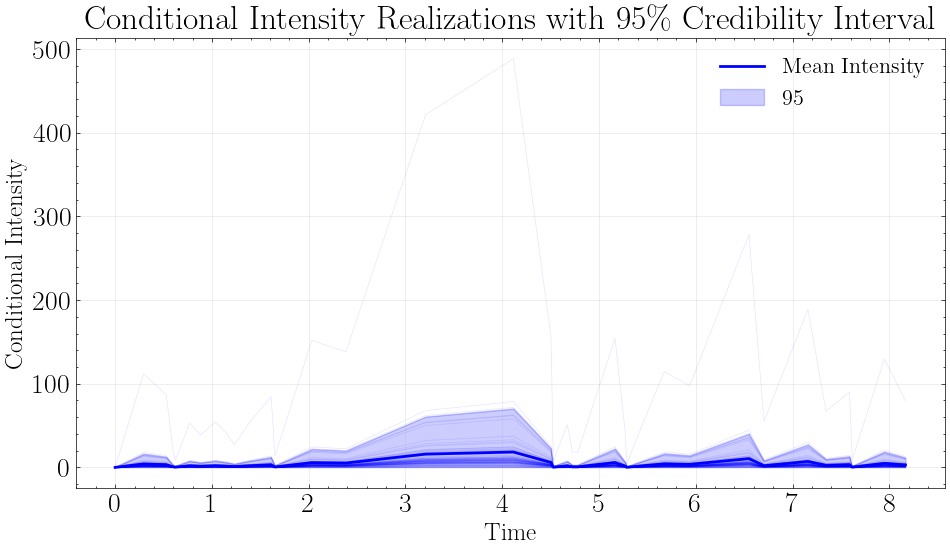

In [35]:
def compute_additional_realizations(vae_model, data_loader, device, num_realizations=50):
    """
    Compute and visualize multiple realizations of the conditional intensity function
    with credibility intervals.
    """
    vae_model.eval()
    
    latent_samples = sample_vae_latent_space(vae_model, data_loader, device)
    
    batch = next(iter(data_loader))
    batch = {k: v.to(device) for k, v in batch.items()}
    sequence_lengths = batch["sequence_length"].to(device)
    
    # Identify the padding tokens
    mask = torch.arange(batch["type_seqs"].size(1)).unsqueeze(0).to(device) < sequence_lengths.unsqueeze(1)
    
    with torch.no_grad():
        time_delta_seqs = batch['time_delta_seqs']
        time_seqs = batch['time_seqs']
        
        time_delta_seq = time_delta_seqs[0]
        time_seq = time_seqs[0]
        seq_mask = mask[0]
        
        # Store all realizations for computing statistics
        all_intensities = []
        time_seq_masked = time_seq[seq_mask]
        
        for latent_sample in latent_samples[:num_realizations]:
            latent_sample_tensor = torch.tensor(latent_sample, device=device, dtype=torch.float32).unsqueeze(0)
            
            print("Shape of latent_sample_tensor: ", latent_sample_tensor.shape)
            time_logits, mark_logits = vae_model.decoder.decode(latent_sample_tensor)
            
            print("Shape of time_logits: ", time_logits.shape)
            cond_intensity = vae_model.criterion.compute_intensity_integral(time_logits, time_delta_seq).squeeze()
            cond_intensity_masked = cond_intensity[seq_mask]
            print("Shape of cond_intensity_masked: ", cond_intensity_masked.shape)
            all_intensities.append(cond_intensity_masked.detach().cpu().numpy())
        
        # Convert to numpy array for easier computation
        all_intensities = np.array(all_intensities)
        time_points = time_seq_masked.detach().cpu().numpy()
        
        # Compute statistics
        mean_intensity = np.mean(all_intensities, axis=0)
        std_intensity = np.std(all_intensities, axis=0)
        
        # Compute 95% credibility interval
        lower_ci = np.percentile(all_intensities, 2.5, axis=0)
        upper_ci = np.percentile(all_intensities, 97.5, axis=0)
        
        # Create the visualization
        plt.figure(figsize=(10, 6))
        
        # Plot individual realizations with low opacity
        for intensity in all_intensities:
            plt.plot(time_points, intensity, color='blue', alpha=0.1, linewidth=0.5)
        
        # Plot mean and credibility intervals
        plt.plot(time_points, mean_intensity, color='blue', linewidth=2, label='Mean Intensity')
        plt.fill_between(time_points, lower_ci, upper_ci, color='blue', alpha=0.2, 
                        label='95% Credibility Interval')
        
        plt.xlabel('Time')
        plt.ylabel('Conditional Intensity')
        plt.title('Conditional Intensity Realizations with 95\% Credibility Interval')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Improve layout
        plt.tight_layout()
        return plt.gcf()
    
    
fig = compute_additional_realizations(vae_model, test_loader, device, num_realizations=100)
plt.savefig('vaetpp_cond_intensity_realizations.png')
plt.show()